In [10]:
%matplotlib inline
import sys
sys.path.append('C:/YandexDisk/Work/RevoBigScorring/')

from tempfile import TemporaryFile
import pandas as pd
import numpy as np
import os
import getpass
import pyodbc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import re
from sklearn.utils import check_consistent_length, column_or_1d, check_array
import Buckets as bc
import woe
import scoringfunctions as sf
import bsfunctions as bs
import time
import random
from scipy import stats
from math import log

from sklearn.utils.fixes import isclose
from sklearn import metrics as met
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import KFold
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
rcParams['figure.figsize'] = 7, 7
pd.options.mode.chained_assignment = None

In [2]:
import imp
woe = imp.reload(woe)
sf = imp.reload(sf)

In [3]:
badFlag = 'badMob3'

In [4]:
connectString = 'DRIVER={SQL Server};SERVER=dwh.int.revoplus.ru;DATABASE=Revo_DW;UID=e.migaev;PWD='
pswd = getpass.getpass('DWH_Password: ')
connectString = connectString + pswd
cnxn = pyodbc.connect(connectString)
pswd = connectString = ''

DWH_Password: ········


In [5]:
query = """select
	fa.clientKey
	,datediff(year,c.BirthDate,c.RegistrationDate) as age
	,c.GenderTypeKey
    ,c.middleName
	,fr.Name as region
	,fcr.[Inquiry12Month]
    ,fcr.[Inquiry1Month]
    ,fcr.[Inquiry1Week]
    ,fcr.[Inquiry3Month]
    ,fcr.[Inquiry6Month]
    ,fcr.[Inquiry9Month]
    ,fcr.[InquiryRecentPeriod]
from
	FicoApplication fa
		left join
	scorOutL 
on
	fa.ClientKey = scorOutL.clientKey
		join
	client c
on
	fa.ClientKey = c.ClientKey
		join
	store s
on
	s.StoreKey = c.StoreKey
		join
	Address a
on
	s.AddressKey = a.AddressKey
		join
	FederalRegion fr
on
	a.FederalRegionKey = fr.FederalRegionKey
		join
	(
		select
			*
			,Row_number() over (partition by ficoapplicationKey order by FicoCreditRegistryKey) as fcrRn
		from
			FicoCreditRegistry 
	)fcr
on
	fcr.ficoApplicationKey = fa.ficoApplicationKey
where
	BkiFlg = 0 and 	scorOutL.clientKey is null 	and c.GenderTypeKey is not null"""

source = pd.read_sql(query,cnxn)

In [6]:
bFlags = pd.read_csv('C:/YandexDisk/Work/Useful/BadFlags/badFlags.csv')
SourceBadFlags = pd.merge(source,bFlags,how='left')

In [7]:
dfVar = SourceBadFlags.copy()
dfVar = dfVar.drop(dfVar[(dfVar.badMob3.notnull())&(dfVar.badFpd.isnull())].index)

In [8]:
middleNames = pd.read_csv('middleNames.csv',sep=';',encoding='cp1251')

In [11]:
def isSlav(x,names):
    for name in names:
        result = re.search(name,x)
        if result: return 1
    return 0

dfVar['isSlav'] = dfVar.middleName.apply(isSlav,args=[middleNames.shortName])

In [50]:
dfVar.loc[dfVar['isSlav']==0].groupby('middleName').size().reset_index().sort_values(0,ascending=False)

,middleName,0
738,Альбертовна,188
4002,Маратовна,127
1027,Артуровна,104
5331,Ринатовна,103
5051,Радиковна,93
2251,Генадьевна,89
3846,Магомедовна,76
6542,Фаритовна,67
5357,Робертовна,65
910,Антоновна,55


In [12]:
grTable = dfVar.groupby('region').agg([np.mean])['badMob3'].reset_index()
dfClean = dfVar[dfVar.badMob3.notnull()]
grSize = dfClean.groupby('region').size().reset_index().rename(columns={0:'size'})

gr = pd.merge(grTable,grSize,how='left')
gr['size'] = gr['size'].astype(float)
gr['size'].fillna(0,inplace=True)

numBins = 5
grGood = gr[gr['size']>50]
grGood['bins'] =  pd.cut(grGood['mean'],numBins)
numTable = grGood.groupby('bins').mean()['mean'].reset_index()
numTable['regionBin'] = range(numBins)
grNum = pd.merge(grGood,numTable[['bins','regionBin']],how='left')

dfVar = pd.merge(dfVar,grNum[['region','regionBin']],how='left')
dfVar.regionBin.fillna(2,inplace=True)
dfVar.loc[dfVar.GenderTypeKey==3,'GenderTypeKey'] = 2

In [13]:
def transInquRec(x):
    if np.isnan(x): return np.nan
    elif x == 0: return 0
    elif x<30: return 1
    elif x == 30: return 30
    elif x<60: return 31
    elif x==60:return 60
    elif x<90:return 61
    elif x==90: return 90
    elif x<180: return 91
    elif x==180: return 180
    elif x<365: return 181
    elif x<367: return x
    else: return 367

dfVarBad = dfVar[dfVar.badMob3.notnull()]
dfVarBad.InquiryRecentPeriod = dfVarBad.InquiryRecentPeriod.apply(transInquRec)

In [14]:
dfBad = dfVarBad.drop(['clientKey','badFpd','region','middleName'],axis=1)
dfPostWoe = dfBad.copy()
dfPostWoe, woeInfo1 = sf.woeVariables(dfPostWoe,'badMob3',rateLimit=0.05,minBins=5,columnChoose=True,columns=['age','regionBin'])
dfPostWoe, woeInfo2 = sf.woeVariables(dfPostWoe,'badMob3',rateLimit=0.15,columnChoose=True,
                                    columns=['Inquiry12Month', 'Inquiry1Month',
                                    'Inquiry1Week', 'Inquiry3Month', 'Inquiry6Month', 'Inquiry9Month','InquiryRecentPeriod'])
dfPostWoe, woeInfo3 = sf.woeVariables(dfPostWoe,'badMob3',rateLimit=0.05,columnChoose=True,columns=['GenderTypeKey','isSlav'])
woeInfo = pd.concat([woeInfo1,woeInfo2,woeInfo3])

Progress: 50.0%, 100.0%, 
Progress: 14.3%, 28.6%, 42.9%, 57.1%, 71.4%, 85.7%, 100.0%, 
Progress: 50.0%, 100.0%, 


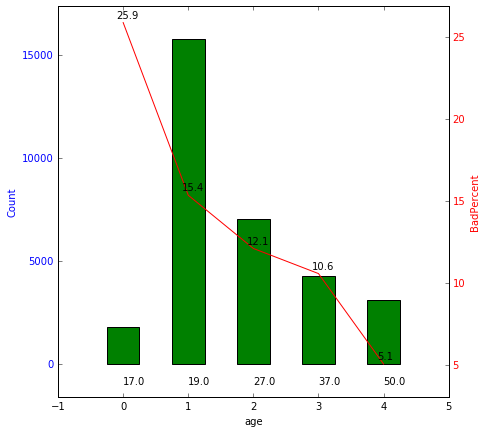

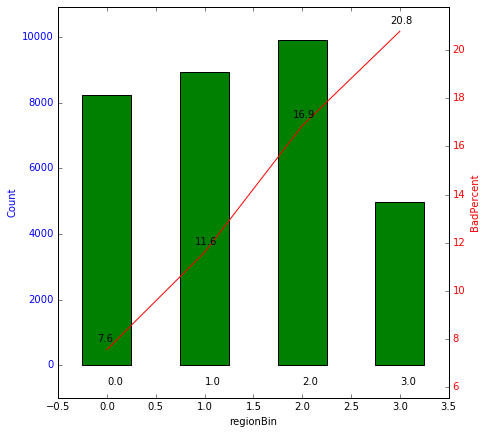

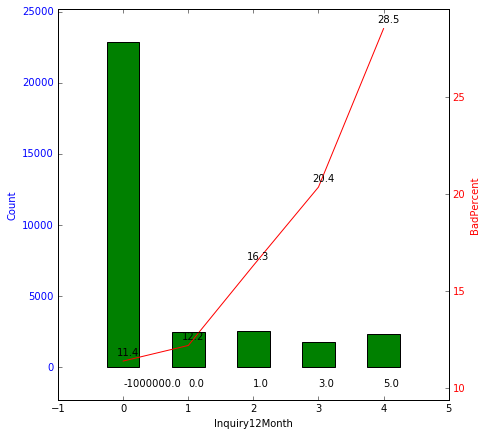

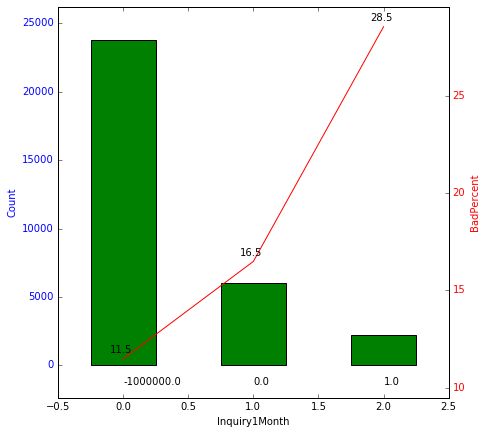

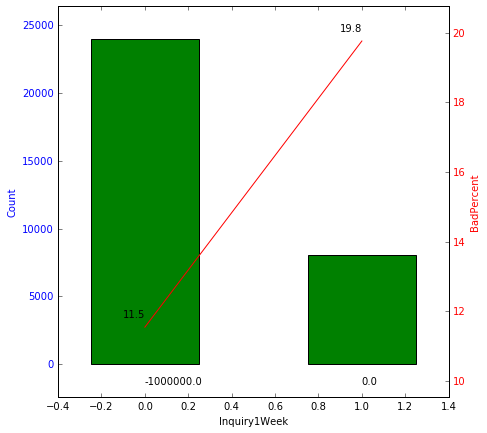

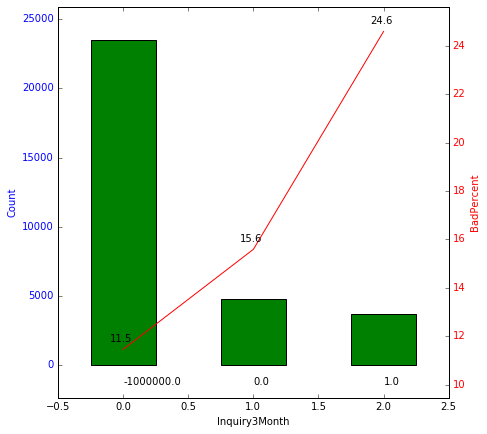

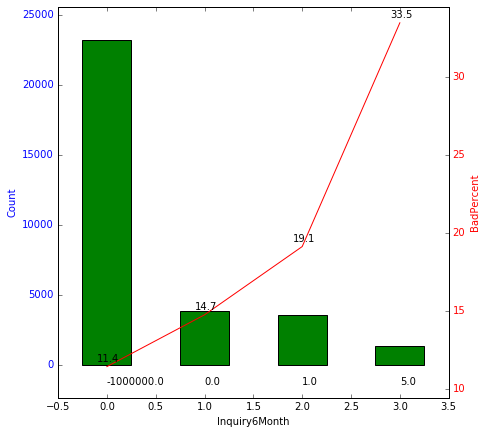

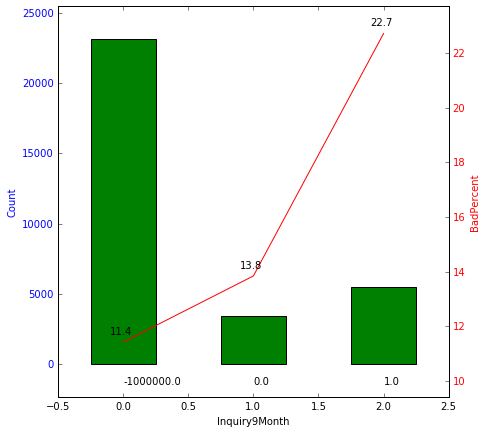

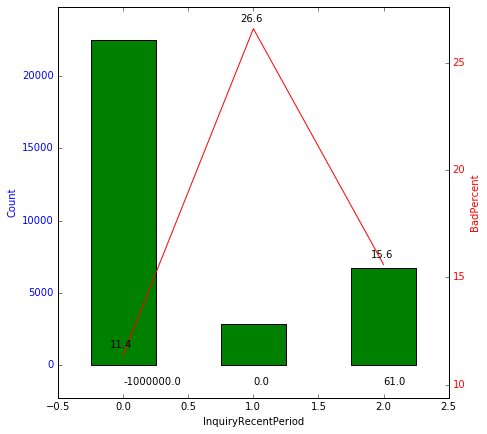

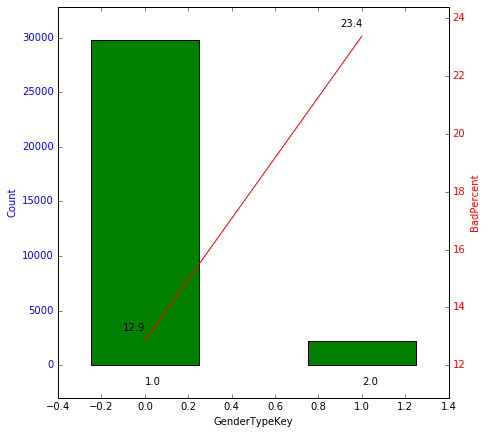

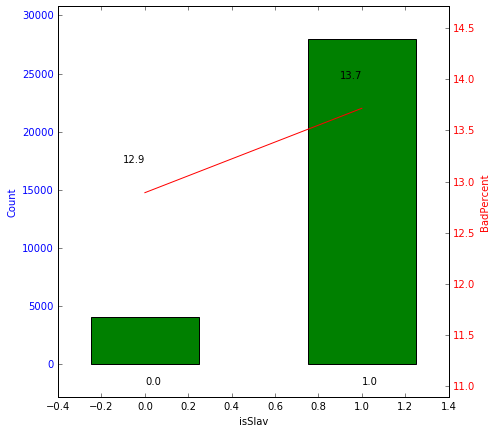

In [15]:
woe.twinPlotWoe(woeInfo)

In [16]:
informationTable = sf.giniGrowth(dfPostWoe, woeInfo, badFlag)

In [17]:
informationTable

,variable,informationValue,testDiff,trainDiff,giniTest,giniTrain
1,regionBin_WOE,0.164591,0.220775,0.219817,0.220775,0.219817
0,age_WOE,0.147988,0.069713,0.075174,0.290488,0.294991
2,Inquiry12Month_WOE,0.135091,0.076899,0.067898,0.367387,0.362890
6,Inquiry6Month_WOE,0.131284,0.000877,0.004908,0.368264,0.367798
3,Inquiry1Month_WOE,0.118536,0.000118,0.004198,0.368383,0.371996
8,InquiryRecentPeriod_WOE,0.113775,-0.000549,-0.000294,0.367833,0.371702
7,Inquiry9Month_WOE,0.109525,0.001956,0.000295,0.369790,0.371998
5,Inquiry3Month_WOE,0.109045,-0.000064,-0.000157,0.369726,0.371841
4,Inquiry1Week_WOE,0.083537,0.001994,0.001717,0.371720,0.373558
9,GenderTypeKey_WOE,0.042141,0.020210,0.012396,0.391930,0.385954


In [19]:
dfPreLr = dfPostWoe.copy()

In [24]:
corDf,dfOg = sf.corrTable(dfPreLr,informationTable)

In [25]:
corDf

,var1,var2,r^2
0,Inquiry12Month_WOE,Inquiry1Month_WOE,0.737024


In [26]:
dfOg

,variable,varCorrelationCount,informationValue
0,Inquiry12Month_WOE,1,0.135091
1,Inquiry1Month_WOE,1,0.118536


In [63]:
list(dfOg.variable)

['Inquiry12Month_WOE',
 'Inquiry1Month_WOE',
 'Inquiry1Week_WOE',
 'Inquiry3Month_WOE',
 'Inquiry6Month_WOE',
 'Inquiry9Month_WOE',
 'InquiryRecentPeriod_WOE']

In [23]:
badColumns = ['Inquiry1Week_WOE','Inquiry3Month_WOE','Inquiry6Month_WOE','Inquiry9Month_WOE','InquiryRecentPeriod_WOE']
goodColumnsPreLr = [x for x in dfPostWoe.columns if x not in badColumns]
dfPreLr = dfPostWoe[goodColumnsPreLr]

In [60]:
len(dfPreLr)

32058

------------------------------------------------------------
train:


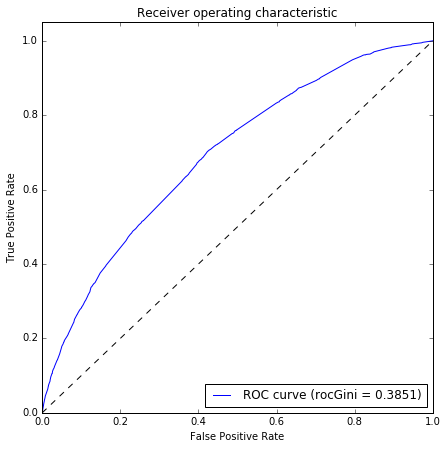

------------------------------------------------------------
test:


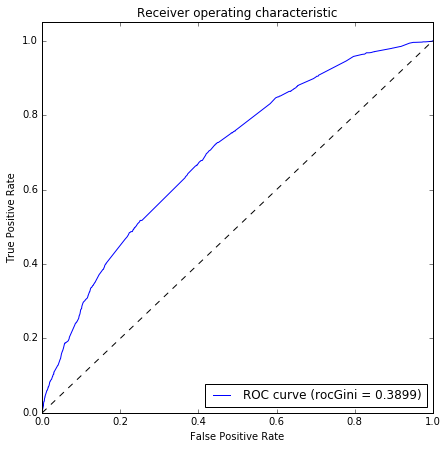

In [30]:
X = dfPreLr.drop('badMob3',axis=1).values
y = dfPreLr.badMob3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=5)
lr = LogisticRegression(C=0.1)
lr.fit(X_train,y_train)

pr_test = lr.predict_proba(X_test)[:,1]
pr_train = lr.predict_proba(X_train)[:,1]

print('-'*60)
print("train:")
sf.rocCurve(y_train,pr_train)
print('-'*60)
print("test:")
sf.rocCurve(y_test,pr_test)

def ageTransform(x):
    if x<23:
        return 0
    elif x<32:
        return 1
    elif x<42:
        return 2
    elif x<55:
        return 3
    else:
        return 4
    
dfHand = dfBad.copy()
dfHand.age = dfHand.age.apply(ageTransform)

In [31]:
factor = 20 / log(2)
offset = 600 - (factor*log(50))

intercept = -(lr.intercept_/len(lr.coef_[0]))*factor + offset/len(lr.coef_[0])
intercept = intercept[0]*len(lr.coef_[0])
intercept

540.16561781513724

In [116]:
goodColumns = [x for x in goodColumnsPreLr if x!='badMob3']

In [118]:
woeOut = sf.woeOutput(woeInfo,goodColumns,lr.coef_,factor)

In [123]:
writer = pd.ExcelWriter('varTransformWithoutCH.xlsx')

sf.woeProduction(woeOut).to_excel(writer,index=False,sheet_name='varTransform')
dfVar[['region','regionBin']].drop_duplicates().sort_values('regionBin').replace(4,3).to_excel(writer,index=False,sheet_name='regions')

writer.save()

In [121]:
dfVar['scoring'] = dfVar.apply(sf.getScoringColumn,args=[woeOut,intercept],axis=1)

In [122]:
dfVar[['clientKey','badMob3','scoring']].to_csv('scorOutWithoutCH.txt',index=False)

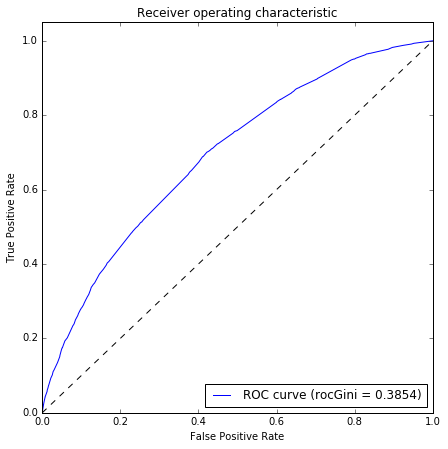

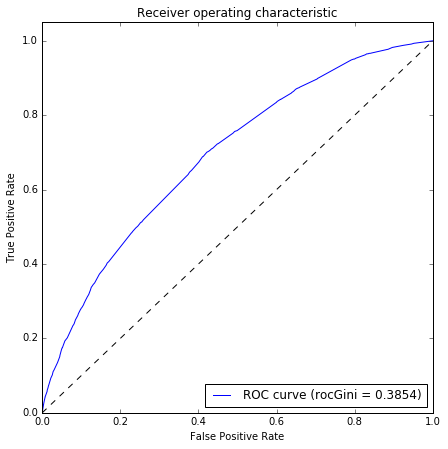

In [126]:
dfCheck = dfVar[dfVar.badMob3.notnull()]
sf.rocCurve(dfCheck.badMob3,lr.predict_proba(X)[:,1])
sf.rocCurve(dfCheck.badMob3,-dfCheck.scoring)

# add QIWI


In [32]:
qiwiSrc = pd.read_csv('C:/YandexDisk/Work/QIWI/qiwisrcWOCH.csv')
qiwiClustInfo = pd.read_csv('C:/YandexDisk/Work/QIWI/qiwiClustInfo.csv')
qiwiWoeInfo = pd.read_csv('C:/YandexDisk/Work/QIWI/qiwiWoeInfo.csv')

qiwiClustInfo = qiwiClustInfo[qiwiClustInfo.variable.apply(sf.preClean).isin(qiwiSrc.columns)]
qiwiWoeInfo =qiwiWoeInfo[qiwiWoeInfo.variable.apply(sf.preClean).isin(qiwiSrc.columns)]

qiwiPostWoe = sf.ootTransform(qiwiSrc,qiwiClustInfo,qiwiWoeInfo,qiwiSrc.columns)


In [38]:
dfCl = pd.concat([dfPreLr,dfVarBad.clientKey],axis=1)

In [43]:
dfWithQiwi = pd.merge(dfCl,qiwiPostWoe.drop('badMob3',axis=1),on='clientKey')

------------------------------------------------------------
train:


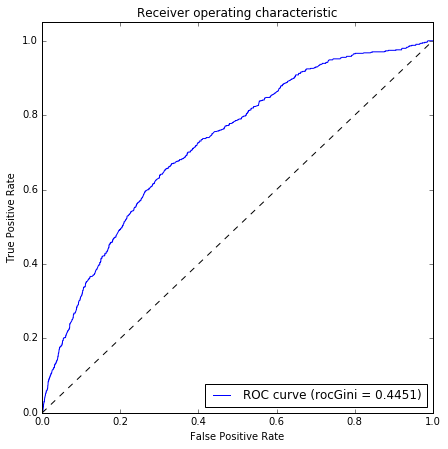

------------------------------------------------------------
test:


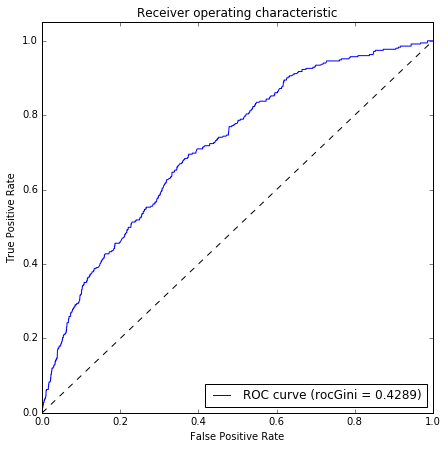

In [54]:
X = dfWithQiwi.drop(['badMob3','clientKey','isSlav_WOE'],axis=1).values
y = dfWithQiwi.badMob3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=5)
lr = LogisticRegression(C=0.1)
lr.fit(X_train,y_train)

pr_test = lr.predict_proba(X_test)[:,1]
pr_train = lr.predict_proba(X_train)[:,1]

print('-'*60)
print("train:")
sf.rocCurve(y_train,pr_train)
print('-'*60)
print("test:")
sf.rocCurve(y_test,pr_test)

In [55]:
qiwiColumns = [x for x in qiwiPostWoe.columns if x!= badFlag]
dfwithoutQiwi = dfWithQiwi.drop(qiwiColumns,axis=1)

------------------------------------------------------------
train:


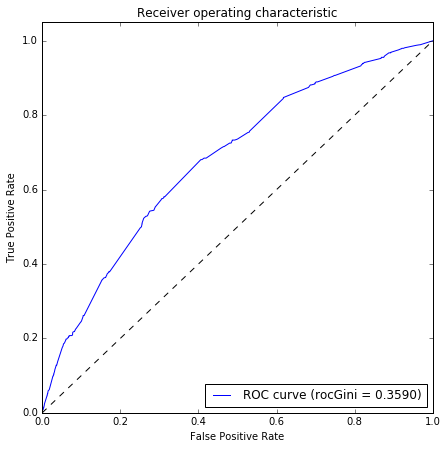

------------------------------------------------------------
test:


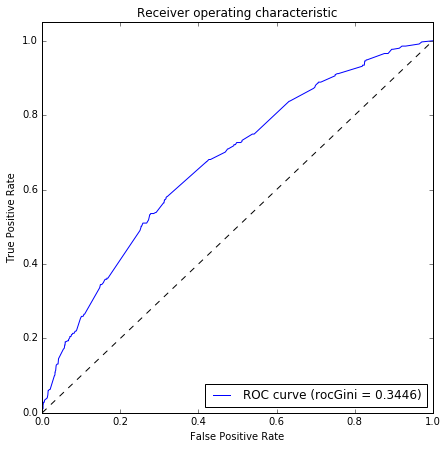

In [57]:
X = dfwithoutQiwi.drop(['badMob3','isSlav_WOE'],axis=1).values
y = dfwithoutQiwi.badMob3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=5)
lr = LogisticRegression(C=0.1)
lr.fit(X_train,y_train)

pr_test = lr.predict_proba(X_test)[:,1]
pr_train = lr.predict_proba(X_train)[:,1]

print('-'*60)
print("train:")
sf.rocCurve(y_train,pr_train)
print('-'*60)
print("test:")
sf.rocCurve(y_test,pr_test)